In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

C:\Users\StudentALARM\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


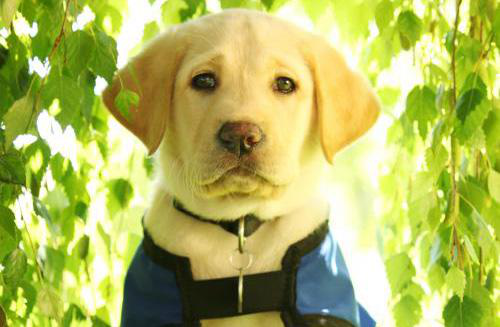

In [2]:
content_image = Image.open('content.jpg')
#content_image = content_image.resize((700,400))
content_image

content_image = Image.open('content.jpg')
content_image = content_image.crop((content_image.size[0] - 1500,
                                    content_image.size[1] - 800,
                                    content_image.size[0] - 400,
                                    content_image.size[1] - 200)).resize((700,400))
content_image

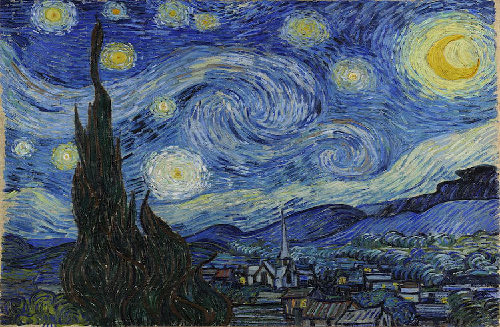

In [3]:
style_image = Image.open('style.jpg')
style_image = style_image.resize((500,327))
style_image

In [4]:
## Turn to array format,add one dimension to combine and check height width and channel
content_array = np.asarray(content_image,dtype='float32')
content_array = np.expand_dims(content_array,axis=0)
content_array.shape

(1, 327, 500, 3)

In [5]:
style_array = np.asarray(style_image,dtype='float32')
style_array = np.expand_dims(style_array,axis=0)
style_array.shape

(1, 327, 500, 3)

In [6]:
### Preprocessing for VGG
MEAN_VALUE = np.array([103.939, 116.779, 123.68])   # BGR
def preprocess(img):
    img = img[:, :, :, ::-1]  # switch to BGR
    img -= MEAN_VALUE
    return img
content_array = preprocess(content_array)
style_array = preprocess(style_array)

In [7]:
## Transform into tensor flow format as input of NN,combination_image is empty,feed it later.
height = style_array.shape[1]
width = style_array.shape[2]
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height,width,3))

In [8]:
## Concatenate 3 images together as input of CNN in VGG16
input_tensor = backend.concatenate([content_image,style_image,combination_image],axis=0)
input_tensor

<tf.Tensor 'concat:0' shape=(3, 327, 500, 3) dtype=float32>

In [9]:
model = VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)

In [10]:
### Extract all layer output for later use
layers=dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 327, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 327, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 163, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 163, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 163, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 81, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 81, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 81, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 81, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 40, 62, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 40, 62, 512) dtype=float32>,
 'block

In [11]:
### Define content loss
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [12]:
content_weight = 1e-4
style_weight = 1

In [13]:
### Take output of block4_conv1 as content features
layer_features = layers['block4_conv1']
content_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss = content_weight*content_loss(content_features,combination_features)
loss

<tf.Tensor 'mul:0' shape=() dtype=float32>

In [14]:
### Define style loss with gram matrix
def gram_matrix(features):
    ### Put the channel first since it represents the filter,then reshape it to 2D n_filter*M as in paper
    features=backend.batch_flatten(backend.permute_dimensions(features,(2,0,1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [15]:
def style_loss(style,combination):
    n_filters = backend.int_shape(style)[2]
    M = backend.int_shape(style)[0]*backend.int_shape(style)[1]
    S=gram_matrix(style)
    C=gram_matrix(combination)
    SL=backend.sum(backend.square(S - C)) / (4. * (n_filters ** 2) * (M ** 2))
    return SL

In [16]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [17]:
### Get the style loss of each layer and add them together with content loss
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    SL = style_loss(style_features,combination_features)
    loss += (style_weight/len(feature_layers))*SL

In [18]:
## Get gradients of combination_image w.r.t. loss
grad = backend.gradients(loss, combination_image)

In [19]:
loss_grad = [loss]
## Add grads after loss. Put them together to save computing time when optimization
if isinstance(grad, (list, tuple)):
    loss_grad += grad
else:
    loss_grad.append(grad)
fun_loss_grad = backend.function([combination_image], loss_grad)

In [20]:
### Get loss and grad with one call
def get_loss_grad(combination_initial):
    combination_initial = combination_initial.reshape((1, height, width, 3))
    ###Feed combination_initial into combination_image
    loss_grad_temp = fun_loss_grad([combination_initial])
    loss_value = loss_grad_temp[0]
    grad_values = loss_grad_temp[1].flatten().astype('float64')
    return loss_value, grad_values

In [21]:
### This class is used to save and pass grad_values after calling function for loss_value. It can avoid calling fun_loss_grad
### twice when we need loss and grad in optimization.
class loss_grad_evaluation(object):
    def __init__(self):
        self.loss_value=None
        self.grad_values=None
    
    def loss(self, x):
        #assert self.loss_value is None
        loss_value, grad_values = get_loss_grad(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grad(self, x):
        #assert self.loss_value is not None
        grad_values = self.grad_values.copy()
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [22]:
## Create a random image with preprocess of VGG
image_random = np.random.uniform(0,255,(1,height,width,3))-128.0
iterations = 15
image_random.shape

(1, 327, 500, 3)

In [23]:
eval = loss_grad_evaluation()

In [24]:
import time
for i in range(iterations):
    print('Iteration %d starts......'%i)
    start_time = time.time()
    image_random, min_loss, info = fmin_l_bfgs_b(eval.loss, image_random.flatten(),
                           fprime=eval.grad,maxfun=30)
    spend_time = time.time() - start_time
    print('Loss:%f\nTime(s):%s'%(min_loss,spend_time))
    print(info)

Iteration 0 starts......
Loss:26370506.000000
Time(s):196.51700019836426
{'grad': array([-2.73775601, -2.8570652 , -4.99613667, ..., -0.32859525,
        0.14198706, -0.24264114]), 'task': b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'funcalls': 31, 'nit': 24, 'warnflag': 1}
Iteration 1 starts......
Loss:18054536.000000
Time(s):194.75404810905457
{'grad': array([-0.84033346, -0.58261007, -0.67659771, ..., -0.16599201,
        0.24564631, -0.09572863]), 'task': b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'funcalls': 31, 'nit': 26, 'warnflag': 1}
Iteration 2 starts......
Loss:15553910.000000
Time(s):194.8577811717987
{'grad': array([-0.0341541 ,  0.02376102, -0.06465118, ..., -0.04674619,
        0.1428231 ,  0.03736807]), 'task': b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'funcalls': 31, 'nit': 26, 'warnflag': 1}
Iteration 3 starts......
Loss:14317473.000000
Time(s):195.79312252998352
{'grad': array([-0.04677736,  0.02433308,  0.12007285, ..., -0.0

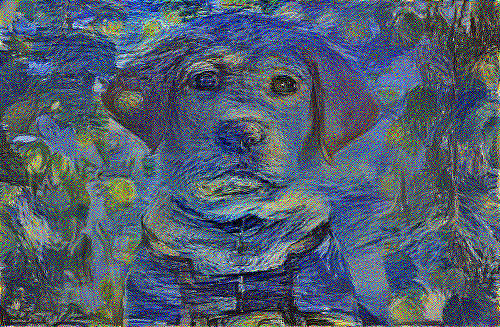

In [25]:
image_random = image_random.reshape((height, width, 3))
def postprocess(img):
    img += MEAN_VALUE
    img = img[:, :, ::-1]  # switch back to RGB    
    return img
combination_final = postprocess(image_random)
### Shrink the value outside (0,255) into edges
combination_final = np.clip(combination_final, 0, 255).astype('uint8')
Image.fromarray(combination_final)

In [ ]:
### this function could make the graph smoother
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))